In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
from inventoryManagement import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="muted")
sns.set_context("talk")

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


In [2]:
def existingATReorderPolicy(inputs):
    if inputs[0] <= 0:
        return -1
    elif inputs[0] > 0 and inputs[0] <= 5:
        return np.floor(5.0/12*inputs[0])
    elif inputs[0] > 5 and inputs[0] < 50:
        return np.floor(5.0/12*inputs[0])
    else:
        return np.floor(inputs[0]/3.0)
        
def existingATMILPolicy(mu):
    if mu <= 0:
        return 0
    elif mu > 0 and mu <= 5:
        return np.ceil(mu)
    elif mu > 5 and mu < 50:
        return np.ceil(2.0/3*mu)
    else:
        return np.ceil(mu/2.0)
        
def proposedATReorderPolicy(inputs):
    if inputs[0] <= 0:
        return -1
    else:
        return np.floor( 1.4*inputs[0]*(inputs[1]+10)/365.0 )
        
def proposedATMILPolicy(mu):
    if mu <= 0:
        return 0
    elif mu > 0 and mu <= 5:
        return np.ceil(mu)
    elif mu > 5 and mu < 50:
        return np.ceil(2.0/3*mu)
    else:
        return np.ceil(mu/2.0)
    
def calculatePerformance(atData, reorderPolicy, milPolicy, milVariable):
    atData['Purchase Volume'] = atData['Total Usage']*atData['Unit Cost']
    atData['Daily Demand'] = atData['Total Usage']/365.0
    atData['theta'] = atData['Daily Demand'] * atData['Lead Time (days)']
    atData['r'] = [ reorderPolicy(inputs) for inputs in zip(atData['Total Usage'], atData['Lead Time (days)'] ) ]
    atData['mil'] = [ milPolicy(mu) for mu in atData[milVariable] ]
    atData['Q'] = atData['mil'] - atData['r']
    atData['Order Frequency'] = atData['Total Usage']/atData['Q']
    atData['Order Interval'] = 365.0/atData['Order Frequency']
    atData['Service Level'] = [min(GPoisson(r, theta), 0.9999) for r, theta in zip(atData['r'], atData['theta'])]
    atData['Fill Rate'] = [SPoisson(Q, r, theta) for Q, r, theta in zip(atData['Q'], atData['r'], atData['theta'])]
    atData['Backorder Level'] = [ BPoisson(Q, r, theta) for Q, r, theta in zip(atData['Q'], atData['r'], atData['theta']) ]
    atData['Inventory Level'] = [ IPoisson(Q, r, theta, b) for Q, r, theta, b in zip(atData['Q'], atData['r'], atData['theta'], atData['Backorder Level']) ]
    atData['I Investment'] = atData['Unit Cost']*atData['Inventory Level']
    atData['Implied A/i_h'] = [ Q**2*c/(2*D) if D >0.1 else 0 for Q, c, D in zip(atData['Q'], atData['Unit Cost'], atData['Total Usage']) ]
    atData['Implied C_s/i_h'] = atData['Unit Cost']*atData['Service Level']/(1-atData['Service Level'])

In [48]:
#Load A&T data
atRawData = pd.read_csv('dcData.csv', ',')
print "Read in %d parts" % len(atRawData)
atRawData = atRawData.loc[(atRawData['Unit Cost'] > 0.0000) & (atRawData['Total Usage'] > 0.0000)]
print "Kept info for %d valid parts" % len(atRawData)

#Analyze current performance
atCurrent = atRawData.copy(deep=True)
calculatePerformance(atCurrent, existingATReorderPolicy, existingATMILPolicy, 'Total Usage')

Read in 219 parts
Kept info for 151 valid parts


In [49]:
#Calculate descriptive statistics
dataForMC = atRawData.copy(deep=True)
dataForMC['Total Usage'] = [ D if D > 0.5 else 0.5 for D in dataForMC['Total Usage'] ]
calculatePerformance(dataForMC, existingATReorderPolicy, existingATMILPolicy, 'Total Usage')

vendors = ['A', 'B', 'C', 'D', 'E']

stats = {}

for vendor in vendors:
    vendorData = dataForMC.loc[(dataForMC['Vendor Code'] == vendor)]
    meanA = vendorData['Implied A/i_h'].mean()
    stdDevA = vendorData['Implied A/i_h'].std()
    stats[vendor] = {'meanA':meanA, 'stdDevA':stdDevA}
    
stats = pd.DataFrame(stats)

In [50]:
stats

,A,B,C,D,E
meanA,36.427482,33.094015,63.405321,26.076923,NaN
stdDevA,64.659441,128.147465,200.387712,26.909566,NaN


In [66]:
parts = []

for i in range(len(atCurrent)):
    #Get current inventory investment, SL, and FR
    currentQ = atCurrent['Q'].values[i]
    #currentI = (atCurrent['Inventory Level'].values[i] - currentQ/2)*atCurrent['Unit Cost'].values[i]
    currentI = atCurrent['I Investment'].values[i]
    currentSL = atCurrent['Service Level'].values[i]
    currentFR = atCurrent['Fill Rate'].values[i]
    
    #Get data for EOQ
    A = stats[atCurrent['Vendor Code'].values[i]][0]
    D = atCurrent['Total Usage'].values[i]
    c = atCurrent['Unit Cost'].values[i]
    i_h = 0.2
    EOQ = max(1, np.sqrt(2.0*A*D/(c*i_h)))
    
    #Calculate efficient frontier
    sls = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
    numPoints = len(sls)
    effFrontier = np.empty((numPoints, 5))
    effFrontier[:,0] = sls
    theta = atCurrent['theta'].values[i]
    effFrontier[:,1] = [ GPoissonInv(sl, th) for sl, th in zip(sls, numPoints*[theta]) ]
    effFrontier[:,2] = [ SPoisson(Q, r, th) for Q, r, th in zip(numPoints*[EOQ], effFrontier[:,1], numPoints*[theta]) ]
    effFrontier[:,3] = [ BPoisson(Q, r, th) for Q, r, th in zip(numPoints*[EOQ], effFrontier[:,1], numPoints*[theta]) ]
    effFrontier[:,4] = [ IPoisson(Q, r, th, B) for Q, r, th, B in zip(numPoints*[EOQ], effFrontier[:,1], numPoints*[theta], effFrontier[:,3]) ]
    effFrontier[:,4] *= c
    
    partData = pd.DataFrame(effFrontier, columns=['SL', 'r', 'FR', 'BO', 'I_Invest'])
    partData['Number'] = atCurrent['Part Number'].values[i]
    partData['Dist From Front'] = currentI - c*IPoisson(EOQ, GPoissonInv(currentSL, theta), theta, BPoisson(EOQ, GPoissonInv(currentSL, theta), theta))
    partData['Current IL'] = currentI
    partData['Current SL'] = currentSL
    partData['Current FR'] = currentFR
    partData['c'] = c
    partData['D'] = D
    partData['A'] = A
    partData['Q'] = currentQ
    partData['EOQ'] = EOQ
    
    parts.append(partData)
    
partsData = pd.concat(parts)
    

In [67]:
partsData

,SL,r,FR,BO,I_Invest,Number,Dist From Front,Current IL,Current SL,Current FR,c,D,A,Q,EOQ
0,0.01,1,0.929397,1.732068e-01,56.790642,930002204-016,-56.831720,17.084026,0.968610,0.993125,1.94,26,33.094015,8,66.597900
1,0.10,3,0.957938,7.522031e-02,60.480548,930002204-016,-56.831720,17.084026,0.968610,0.993125,1.94,26,33.094015,8,66.597900
2,0.20,4,0.970247,4.546769e-02,62.362828,930002204-016,-56.831720,17.084026,0.968610,0.993125,1.94,26,33.094015,8,66.597900
3,0.30,4,0.970247,4.546769e-02,62.362828,930002204-016,-56.831720,17.084026,0.968610,0.993125,1.94,26,33.094015,8,66.597900
4,0.40,5,0.980347,2.581424e-02,64.264700,930002204-016,-56.831720,17.084026,0.968610,0.993125,1.94,26,33.094015,8,66.597900
5,0.50,6,0.987926,1.374039e-02,66.181277,930002204-016,-56.831720,17.084026,0.968610,0.993125,1.94,26,33.094015,8,66.597900
6,0.60,6,0.987926,1.374039e-02,66.181277,930002204-016,-56.831720,17.084026,0.968610,0.993125,1.94,26,33.094015,8,66.597900
7,0.70,7,0.993113,6.853114e-03,68.107916,930002204-016,-56.831720,17.084026,0.968610,0.993125,1.94,26,33.094015,8,66.597900
8,0.80,8,0.996351,3.204286e-03,70.040837,930002204-016,-56.831720,17.084026,0.968610,0.993125,1.94,26,33.094015,8,66.597900
9,0.90,9,0.998202,1.406192e-03,71.977349,930002204-016,-56.831720,17.084026,0.968610,0.993125,1.94,26,33.094015,8,66.597900


In [53]:
data = partsData.sort_values(['Dist From Front', 'Number'], ascending=False)
data = data.loc[data['Dist From Front'] > 0]
print len(data)/11

2


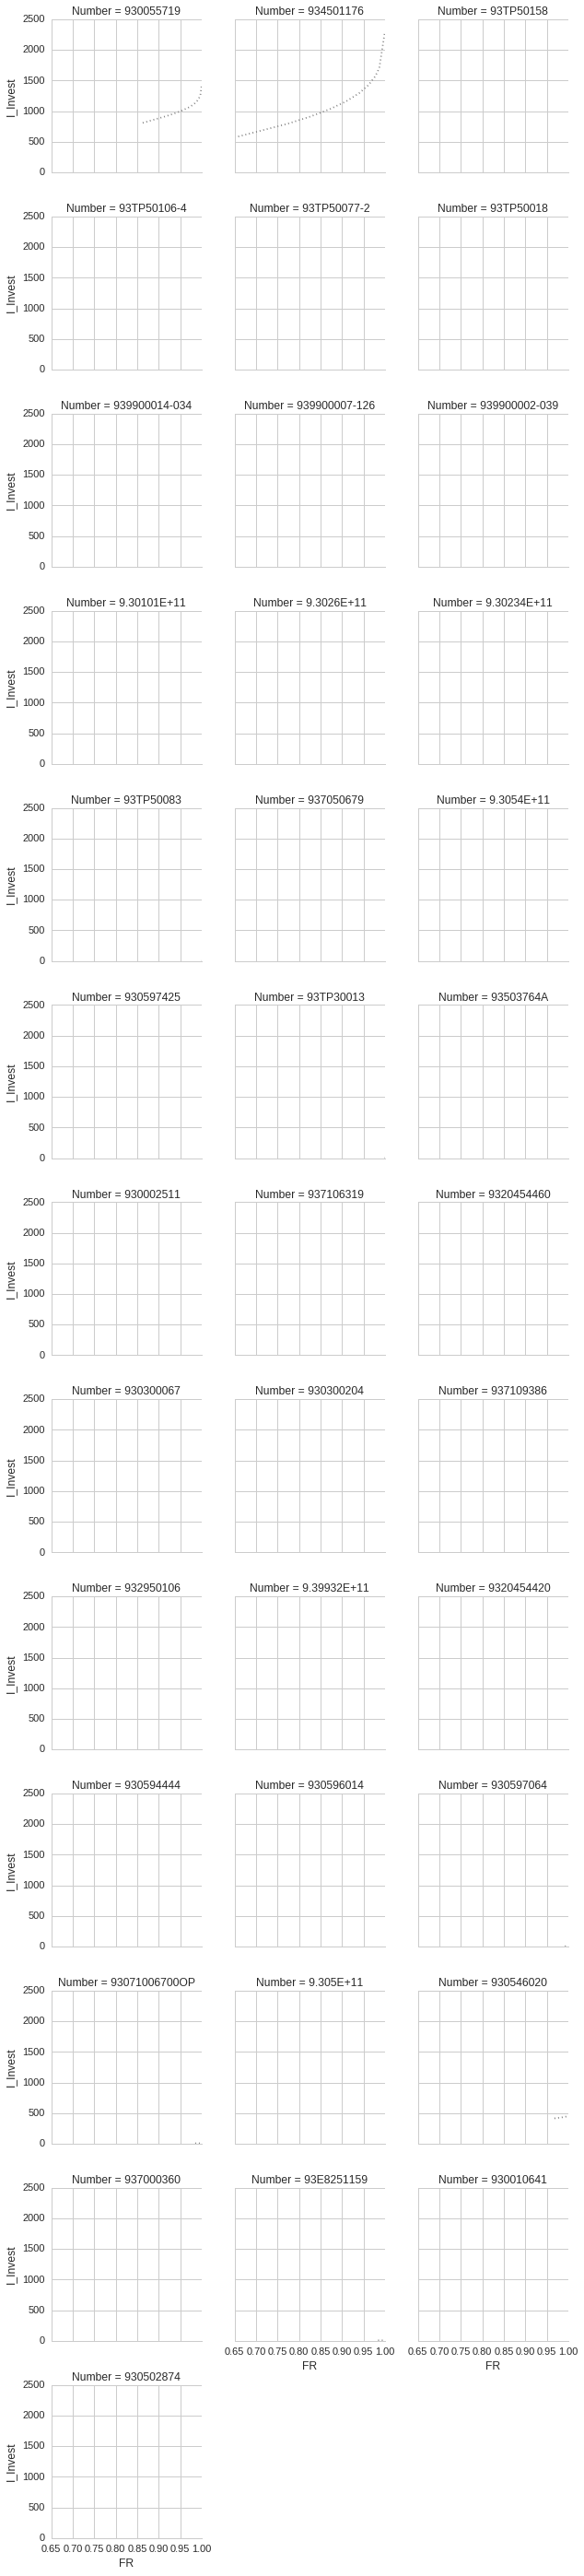

In [47]:
sns.set_context("notebook", font_scale=1.1)
grid = sns.FacetGrid(data, col='Number', col_wrap=3, hue='Number')
grid.map(plt.plot, 'FR', 'I_Invest', ls=":", c=".5")

# g = (g.map(plt.scatter, "FR", "I_Invest", edgecolor="w")).add_legend()
# g.set_xlabels('Fill Rate')
# g.set_ylabels('I Investment (USD)')
# g.set(xlim=(0.6,1), xticks=[0.6, 0.7, 0.8, 0.9, 1.0],ylim=(1e4,6e4))
# g.set_titles("i_h = {col_name} | A = mu + {row_name}*sigma")
# g.savefig('Sweep_Of_Costs.png', dpi=100, facecolor='#FFFFFF')

### Usage by Vendor

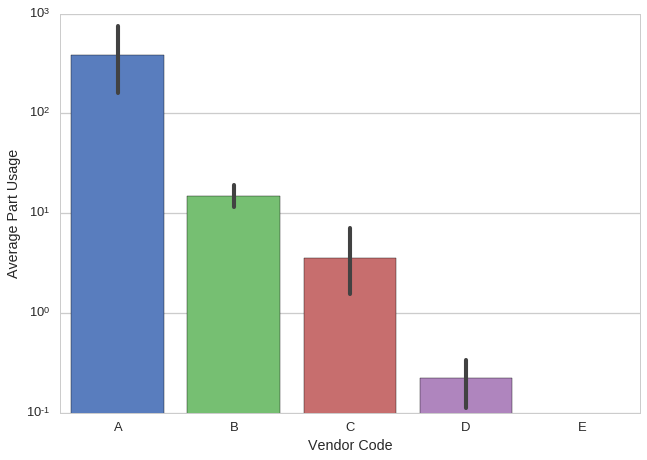

In [6]:
data = atCurrent
g = sns.barplot(x='Vendor Code', y="Total Usage", data=data, order=['A', 'B', 'C', 'D', 'E'])
g.set(yscale="log")
g.set_ylabel('Average Part Usage')
#g.set_title('Part Purchase Volume By Vendor')

### Average Part Cost by Vendor

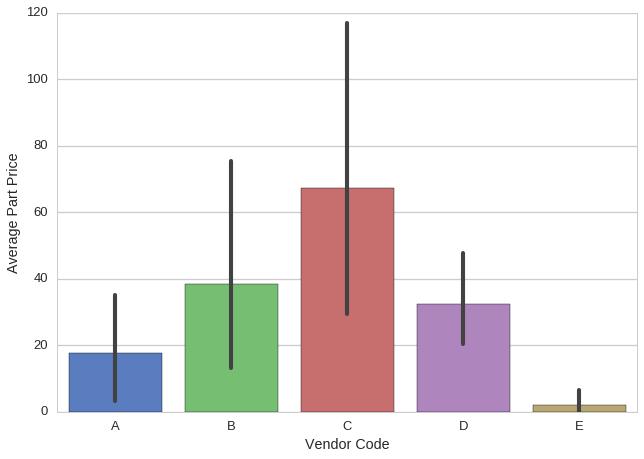

In [7]:
data = atCurrent
g = sns.barplot(x='Vendor Code', y="Unit Cost", data=data, order=['A', 'B', 'C', 'D', 'E'])
#g.set(yscale="log")
g.set_ylabel('Average Part Price')
#g.set_title('Part Price By Vendor')

### Purchase Volume by Vendor

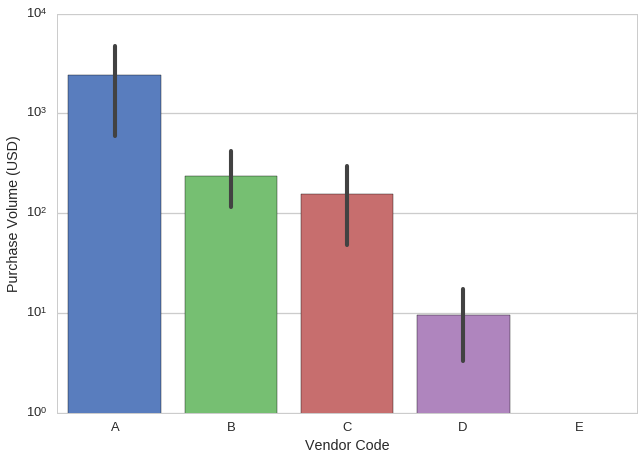

In [8]:
data = atCurrent
g = sns.barplot(x='Vendor Code', y="Purchase Volume", data=data, order=['A', 'B', 'C', 'D', 'E'])
g.set(yscale="log")
g.set_ylabel('Purchase Volume (USD)')
#g.set_title('Comparison of Mean Purchase Volume From Vendors')

### Implied Fixed Order Cost by Vendor

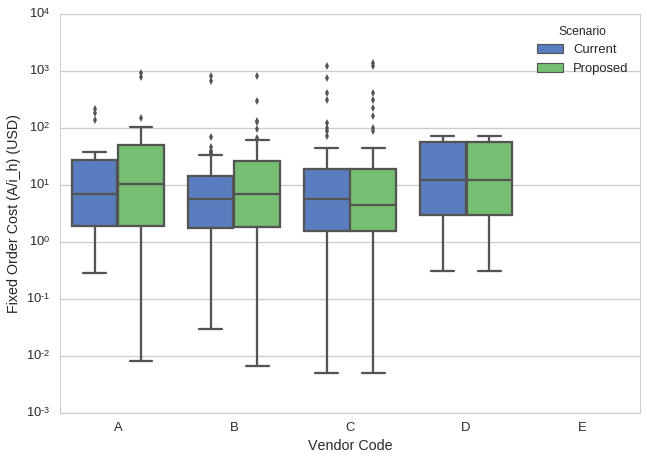

In [7]:
data = atAll.loc[atCurrent['Total Usage'] > 0]
g = sns.boxplot(x='Vendor Code', y="Implied A/i_h", data=data, hue='Scenario', order=['A', 'B', 'C', 'D', 'E'])
g.set(yscale="log")
g.set_ylabel('Fixed Order Cost (A/i_h) (USD)')
#g.set_title('Comparison of Implied Fixed Order Costs by Vendor')

### Implied Shortage Cost by Vendor

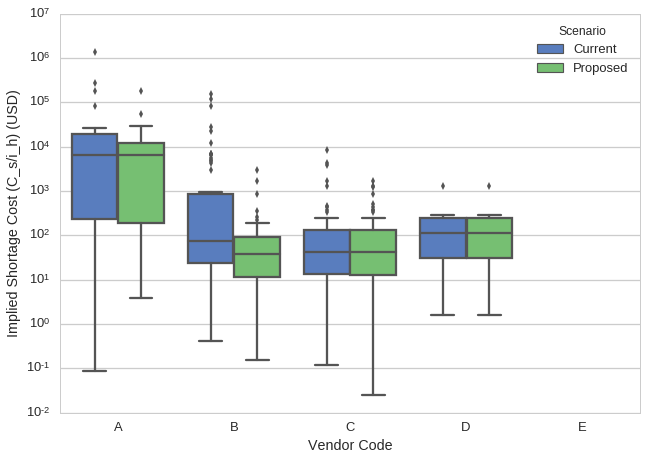

In [8]:
data = atAll.loc[atCurrent['Total Usage'] > 0]
g = sns.boxplot(x='Vendor Code', y="Implied C_s/i_h", data=data, hue='Scenario', order=['A', 'B', 'C', 'D', 'E'])
g.set(yscale="log")
g.set_ylabel('Implied Shortage Cost (C_s/i_h) (USD)')
#g.set_title('Comparison of Implied Shortage Costs by Vendor')

### Inventory Investment by Vendor

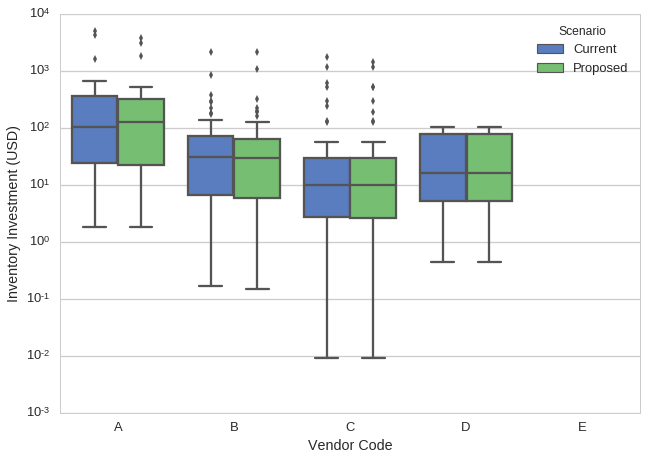

In [9]:
data = atAll.loc[atCurrent['Total Usage'] > 0]
g = sns.boxplot(x='Vendor Code', y="I Investment", data=data, hue='Scenario', order=['A', 'B', 'C', 'D', 'E'])
g.set(yscale='log')
g.set_ylabel('Inventory Investment (USD)')
#g.set_title('Comparison of Inventory Investment by Vendor')

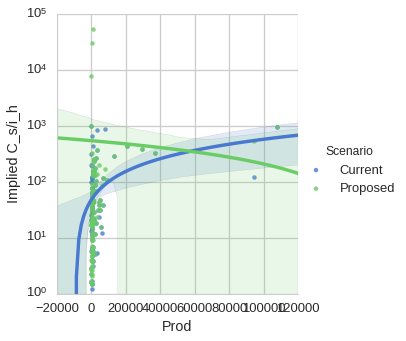

In [186]:
data = atAll.loc[atCurrent['Implied C_s/i_h'] < 1000].copy(deep=True)
data['Prod'] = data['Lead Time (days)']*data['Unit Cost']
g = sns.lmplot(x='Prod', y='Implied C_s/i_h', data=data, hue='Scenario')
g.set(yscale='log')

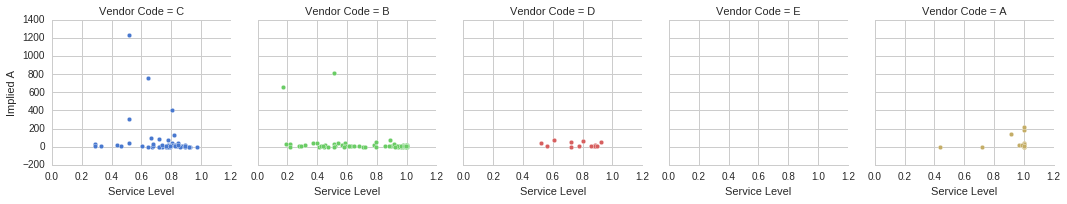

In [35]:
g = sns.FacetGrid(atCurrent, col="Vendor Code",  hue="Vendor Code")
g = (g.map(plt.scatter, "Service Level", "Implied A", edgecolor="w"))

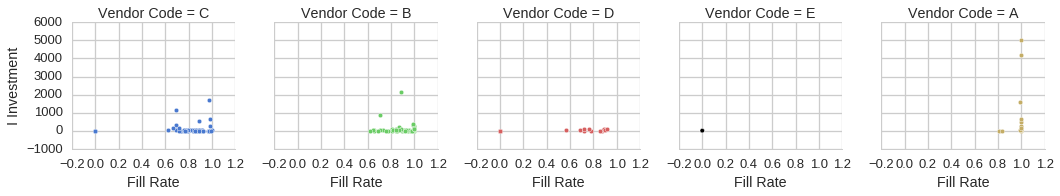

In [22]:
data = atCurrent
g = sns.FacetGrid(data, col="Vendor Code",  hue="Vendor Code")
g = (g.map(plt.scatter, "Fill Rate", 'I Investment', edgecolor="w"))

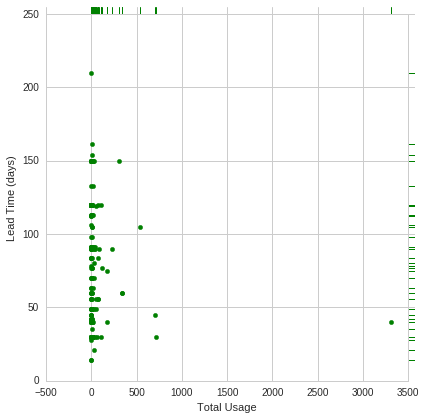

In [11]:
grid = sns.JointGrid(x="Total Usage", y="Lead Time (days)", data=atCurrent, space=0, size=6, ratio=50)
grid.plot_joint(plt.scatter, color="g")
grid.plot_marginals(sns.rugplot, height=1, color="g")